# LA Clippers Data Challenge
### Author: Sid Nagaich
#### Date: Dec-Jan 2021


In summary, in this notebook I answer the 5 questions asked in Part 1, design and train a densly connected Neural Network in part 2 (also a poorly-working Gradient Boosted Trees model for comparison...), and finally explain how I gathered the necessary information from outside sources to actually generate predictions for attendance during the 2019-2020 season. Notably, I used some advanced player analytics (https://projects.fivethirtyeight.com/nba-player-ratings/) from on Kawhi Leonard and Paul George, who were two major pickups for the Clippers during this exercise's offseason, to try and account for their impacts on team performance my attendance predictions. __Predictions for the attendance of the first 32 LAC home games (after which the NBA was suspended due to Covid-19) are shown at the end of the notebook.__

## Project Setup

In [213]:
# import needed libraries
import pandas as pd
import numpy as np
!pip install pandasql
from pandasql import sqldf
import numpy as np 
from matplotlib import pyplot as plt
from scipy import stats
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# load raw data into dataframes
team = pd.read_excel('Interview Project Data.xlsx', sheet_name='Team Data')
game = pd.read_excel('Interview Project Data.xlsx', sheet_name='Game Data')
seat = pd.read_excel('Interview Project Data.xlsx', sheet_name='Seating Chart')
price = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Price Data')
scan = pd.read_excel('Interview Project Data.xlsx', sheet_name='Ticket Scan Data')

In [3]:
# check loaded data
game.head()

,Game Number,Date,Start Time,Game Type,Opponent,Result,Overtime,Clippers Points,Opponent Points,Total Wins,Total Losses,Streak
0,1,"Wed, Oct 17, 2018",10:30p,Regular Season Home,Denver Nuggets,L,No,98,107,0,1,L 1
1,2,"Fri, Oct 19, 2018",10:30p,Regular Season Home,Oklahoma City Thunder,W,No,108,92,1,1,W 1
2,3,"Sun, Oct 21, 2018",9:00p,Regular Season Home,Houston Rockets,W,No,115,112,2,1,W 2
3,4,"Tue, Oct 23, 2018",8:00p,Regular Season Away,New Orleans Pelicans,L,No,109,116,2,2,L 1
4,5,"Fri, Oct 26, 2018",8:00p,Regular Season Away,Houston Rockets,W,No,133,113,3,2,W 1


## Part 1: (Word Document) answering the following questions with graphs or tables:

### 1) [SQL] Do weekend games (Friday, Saturday, Sunday), on average, have a higher attendance than weekday games (Monday through Thursday)?

Much of our work in this question will serve us in the future questions of Part 1 of the Data Challenge. We start by using SQL queries on our dataframes to count the number of scanned tickets per game. We will also parse dates from the given information to later be useful in inner-joins. Subsequent steps are explained.

In [4]:
# count the number of scanned tickets per home game
game_attendance = sqldf("SELECT event_name as Game, count(*) as Attendance \
                            FROM scan GROUP by event_name ORDER BY count(*) DESC")

# create a date column from [Game]
game_date = game_attendance['Game'].str.split('-').str[3]
# standardize to Date Time object
game_date = pd.to_datetime(game_date).dt.date

# add parsed columns to dataframe
game_attendance['Date'] = game_date

# show df
game_attendance.head()

,Game,Attendance,Date
0,LA Clippers 2018-2019 Game 24 - Golden State -...,10445,2019-01-18
1,LA Clippers 2018-2019 Game 32 - Boston - 03/11/19,10101,2019-03-11
2,LA Clippers 2018-2019 Game 17 - San Antonio - ...,10089,2018-12-29
3,LA Clippers 2018-2019 Game 27 - Los Angeles - ...,10034,2019-01-31
4,LA Clippers 2018-2019 Game 29 - Dallas - 02/25/19,9716,2019-02-25


We now select all home games and parse both the date and the day of the week of the game.

In [5]:
# select all home games
home_games = sqldf("SELECT Date, [Game Type], Opponent FROM game WHERE [Game Type] LIKE '%Regular Season Home%'")

# get day of the week from [Date]
day_of_week = home_games['Date'].str.split(',').str[0]

# get dates
dates = home_games['Date'].str.split(',').str[1] + home_games['Date'].str.split(',').str[2]
# standardize to Date Time object
dates = pd.to_datetime(dates).dt.date

# replace [Date] and add [Day] columns
home_games['Date'] = dates
home_games['Day'] = day_of_week

# show df
home_games.head()

,Date,Game Type,Opponent,Day
0,2018-10-17,Regular Season Home,Denver Nuggets,Wed
1,2018-10-19,Regular Season Home,Oklahoma City Thunder,Fri
2,2018-10-21,Regular Season Home,Houston Rockets,Sun
3,2018-10-28,Regular Season Home,Washington Wizards,Sun
4,2018-11-05,Regular Season Home,Minnesota Timberwolves,Mon


We will now select the games based on the day of the week so that we can calculate averages for both weekday and weekend games. We do this by using an inner join with the attendance table above.

In [6]:
# select weekend games
weekdays = sqldf("SELECT * from home_games WHERE Day LIKE 'Mon' OR Day LIKE 'Tue' OR Day LIKE 'Wed' OR Day LIKE 'Thu'")
weekends = sqldf("SELECT * from home_games WHERE Day LIKE 'Fri' OR Day LIKE 'Sat' OR Day LIKE 'Sun'")

# join the above tables with game_attendance to compare average attendances
averages = sqldf("SELECT AVG(Attendance) as 'Average Weekday Attendance' FROM game_attendance INNER JOIN weekdays on weekdays.Date = game_attendance.Date")
averages['Average Weekend Attendance'] = sqldf("SELECT AVG(Attendance) FROM game_attendance INNER JOIN weekends on weekends.Date = game_attendance.Date")

# show means
averages

,Average Weekday Attendance,Average Weekend Attendance
0,8356.272727,8507.105263


We can see that there is, on average, slightly higher attendance on weekends. To get a more detailed look, we can visualize the average attendance per day.

,Day,Average Attendance
0,Thu,8981.333333
1,Sat,8594.333333
2,Sun,8499.142857
3,Mon,8467.000000
4,Fri,8429.166667
5,Wed,8298.428571
6,Tue,7907.200000


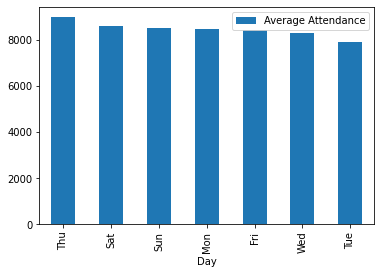

In [7]:
# join all home games and attendance on date
visual = sqldf("SELECT Day, AVG(Attendance) as 'Average Attendance' FROM game_attendance \
                INNER JOIN home_games on home_games.Date = game_attendance.Date \
                GROUP BY Day ORDER BY AVG(Attendance) DESC")
# plot bar chart
visual.plot.bar(x = 'Day')
# show attendances by day
visual

In [8]:
# get stats
visual.describe()

,Average Attendance
count,7.000000
mean,8453.800680
std,322.436012
min,7907.200000
25%,8363.797619
50%,8467.000000
75%,8546.738095
max,8981.333333


Average attendance per day does not differ by more than two standard deviations from the mean for a given day, so we cannot conclude that any differences between the days are statistically significant (assuming an alpha = 0.05). 

### 2) [SQL] Identify and rank the top 4 opponents with the highest average number of attendances.
To answer this question, we can join our previous game_attendance table with our home_games table on the date which the games were played. Since we know the attendance of each game and who the games were played against, we can then calculate the average attendance per opponent.

In [9]:
opp_attendance = sqldf("SELECT Opponent, AVG(Attendance) as 'Average Attendance' FROM game_attendance \
                        INNER JOIN home_games ON home_games.Date = game_attendance.Date \
                        GROUP BY Opponent ORDER BY AVG(Attendance) DESC LIMIT 4")
opp_attendance

,Opponent,Average Attendance
0,Boston Celtics,10101.0
1,Golden State Warriors,9797.5
2,Los Angeles Lakers,9477.0
3,New York Knicks,9432.0


### 3) Identify and rank the top 10 sections that are, on average, the most filled to their capacity.
To answer this question we will join two SQL SELECT statements which gather the required information. We first sum the available seats in each section, and next calculate the average number of tickets that scanned into each section. We will use these values to calculate the proportion of the section that is full, on average. Finally, we will sort by how full the section is on average and limit our results to the top 10 sections.

In [10]:
# note that we could omit the Capacity and Average Attendance columns
section_capacities = sqldf("SELECT t1.Section, Capacity, [Average Attendance],\
                            CAST([Average Attendance] as FLOAT) / CAST(Capacity as FLOAT) as 'Proportion Filled' FROM \
                            (SELECT seat.section_name as Section, SUM(seat.seat_count) as Capacity \
                                FROM seat GROUP BY seat.section_name) t1 \
                            INNER JOIN \
                            (SELECT scan.section_name as Section, count(scan.section_name)/41 as 'Average Attendance' \
                                FROM scan GROUP BY scan.section_name) t2 \
                            ON t1.Section = t2.Section ORDER BY (CAST([Average Attendance] as FLOAT) / CAST(Capacity as FLOAT)) \
                                DESC LIMIT 10")
section_capacities

,Section,Capacity,Average Attendance,Proportion Filled
0,207,187,148,0.791444
1,309,89,70,0.786517
2,106,531,417,0.785311
3,118,216,168,0.777778
4,116,532,411,0.772556
5,215,192,148,0.770833
6,206,195,149,0.764103
7,105,254,194,0.763780
8,310,89,67,0.752809
9,217,186,140,0.752688


### 4) Is there a correlation between the opponent team having a higher Vegas Odds Score (indicating higher probability of winning a championship) and higher attendance?
To answer this question we will use our previous statement from Q2 and join it on the team table by matching the Team Full Name with the Opponent names we used before. From the team table we can get the Vegas Odds per opponent and use it alongside the weekly attendance to visualize and analyze our data to see if there is a correlation between Vegas Odds and attendance.

In [11]:
# this will overwrite the query in Question 2
opp_attendance = sqldf("SELECT Opponent, [Average Attendance], [Vegas Odds for 1819] as 'Opponent Vegas Odds' FROM \
                        (SELECT Opponent, AVG(Attendance) as 'Average Attendance' FROM game_attendance \
                            INNER JOIN home_games ON home_games.Date = game_attendance.Date \
                            GROUP BY Opponent) t1 \
                        INNER JOIN \
                        (SELECT [Team Full Name], [Vegas Odds for 1819] FROM team GROUP BY [Team Full Name]) t2 \
                        ON t1.Opponent = t2.[Team Full Name] ORDER BY [Vegas Odds for 1819] DESC")

# show data
opp_attendance.head()

,Opponent,Average Attendance,Opponent Vegas Odds
0,Golden State Warriors,9797.5,62.5
1,Boston Celtics,10101.0,57.5
2,Houston Rockets,8109.5,54.5
3,Philadelphia 76ers,8904.0,54.5
4,Toronto Raptors,8885.0,54.5


Here we will use pyplot to visualize the data.

R: 0.216079
R-squared: 0.046690


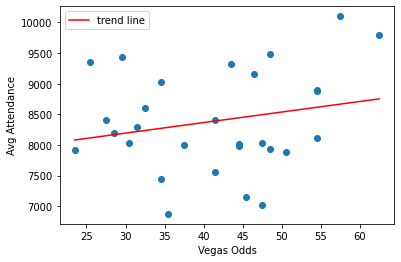

In [134]:
x = opp_attendance["Opponent Vegas Odds"]
y = opp_attendance["Average Attendance"]

res = stats.linregress(x, y)

print(f"R: {res.rvalue:.6f}")
print(f"R-squared: {res.rvalue**2:.6f}")

plt.plot(x, y, 'o')
plt.xlabel("Vegas Odds")
plt.ylabel("Avg Attendance")
plt.plot(x, res.intercept + res.slope*x, 'r', label='trend line')
plt.legend()
plt.show()

We observe a weak positive correlation between the opponent's Vegas odds and game attendance such that higher Vegas odds are associated with higher attendance.

### 5) On average, which 15-minute period before or after the start of a game has the highest number of people scanning. (Example 30 – 16 minutes prior to the start of a game)
To answer this question we will subtract the game's start time from the ticket scan time (and adjust for the time difference). Negative results will indicate that the spectator scanned after the game had started. We then define 15-minute intervals in which we will count the ticket scans. We can then compare which time interval is the most popular for scanning.

In [13]:
# convert to datetime object
scan['event_datetime'] = pd.to_datetime(scan['event_datetime'])
scan['scan_datetime'] = pd.to_datetime(scan['scan_datetime'])

In [14]:
# note we are converting from days to minutes by multiplying by 1440 
# and adjusting for the time zone difference by adding 120
minutes = sqldf("SELECT event_name, ROUND((JULIANDAY(event_datetime) - JULIANDAY(scan_datetime)) \
                    * 1440 + 120) AS 'minutes' FROM scan;")
minutes.head()


,event_name,minutes
0,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,38.0
1,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,5.0
2,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,87.0
3,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,42.0
4,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,7.0


Here we define buckets in which we will count our data.

In [15]:
# define buckets table
# note: the question specifies before or after the start time so we are not looking at exactly "on time" scans
buckets = {
    'Range': ['46-60 minutes before', '31-45 minutes before', '16-30 minutes before', '1-15 minutes before', 
               '1-15 minutes after', '16-30 minutes after', '31-45 minutes after', '46-60 minutes after'], 
    'LowerLim': [46, 31, 16, 1, -15, -30, -45, -60], 
    'UpperLim': [15, 30, 45, 60, -1, -16, -31, -46]
    }
buckets = pd.DataFrame(data=buckets)
buckets

,Range,LowerLim,UpperLim
0,46-60 minutes before,46,15
1,31-45 minutes before,31,30
2,16-30 minutes before,16,45
3,1-15 minutes before,1,60
4,1-15 minutes after,-15,-1
5,16-30 minutes after,-30,-16
6,31-45 minutes after,-45,-31
7,46-60 minutes after,-60,-46


In [16]:
# count total scans within each time interval
count = sqldf("SELECT Range as Timing, Count(*) as 'Ticket Scans' FROM \
               buckets r INNER JOIN minutes m ON m.minutes BETWEEN r.LowerLim and r.UpperLim \
               GROUP BY Range ORDER BY Count(*) DESC")

count.head()

,Timing,Ticket Scans
0,1-15 minutes before,174943
1,16-30 minutes before,87869
2,1-15 minutes after,54087
3,16-30 minutes after,28607
4,31-45 minutes after,13612


Now that we have the total number of ticket scans within each interval, we divide these by the number of home games to view the average number of people scanning tickets within each interval at a given game.

In [17]:
# divide Ticket Scan totals within each interval by number of home games
count['Ticket Scans'] = count['Ticket Scans'] / len(home_games.index) # number of home games
count.head()

,Timing,Ticket Scans
0,1-15 minutes before,4266.902439
1,16-30 minutes before,2143.146341
2,1-15 minutes after,1319.195122
3,16-30 minutes after,697.731707
4,31-45 minutes after,332.000000


Here we can see that 1-15 minutes before the start of a game has the most people scanning.

<AxesSubplot:xlabel='Timing'>

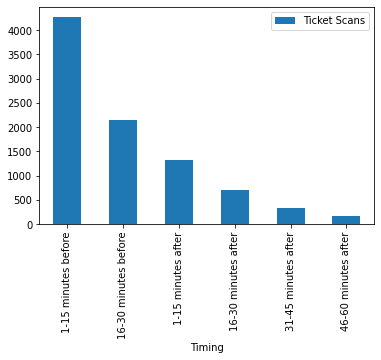

In [18]:
# plot bar chart
count.plot.bar(x = 'Timing')

## Part 2: PowerPoint Presentation with Video/Screen Recording:

### Develop a model to predict the at regular season games attendance

As you are aware, most of the work here is in attaining and/or prepping the data. Once we have coded and cleaned our data, we will select a reasonable training/test split (perhaps a validation split too, but we are not working with a large amount of data) and be able to begin training the various models. We will then select the best performing model and see how well it can predict the per-game attendance, which will be our target variable. Another event to note when using this model to predict future seasons is the Covid-19 pandemic. The NBA had "the Bubble" and all sorts of wonkiness amidst the pandemic, so we would need to further examine how predictive some aspects of the historical data has remained.

##### Feature Selection
Perhaps the most exciting part about data science, for me, is being able to critically think about what variables are going to be the most predictive for a desired outcome. As data scientists, we get to hone our insights and select features that we believe will make our model work. We will use a densly connected Neural Network (NN). Some thought was put into potentially using a Recurrent Neural Network (RNN), though since we are predicting the entirety of next season before the season begins I opted against it. I believe the RNN would be more suited to predict games in the near future given any ongoing conditions within a season. We will also test a Gradient Boosted Tree model, though I expect it to be unable to perform well given the limited training data. While I'm confident that the NN will outperform the Decision Tree model, even recent publications seem to have positive findings using Decision Trees in similar tasks.

We will test a wide range of data to see what is predictive. While I certainly do not believe that selecting poor features is a good practice, I am generally a fan of casting a wide net, especially when using Neural Networks, as many of the weights of non-predictive features will approach zero.

Our selected features are as follows:
- Date Information: 
    - Game Number, Month, Day of week, Date (day in 'dd' form), Start Time
- Game Information: 
    - Last Result (last game), Lagged Result (two games ago), Overtime (last game), Overtime (two games ago), Last Clippers Score (last game), Lagged Clippers Score (two games ago), Last Opponent Score (last game), Lagged Opponent Score (two games ago)
- Season Information*: 
    - Total Wins, Total Losses
- Opponent Information: 
    - Opponent Name, Opponent in Playoffs Last Year, Championships, Vegas Odds
- Pricing*: 
    - Average ticket price


*W/L totals will be from the end of last game since we cannot see into the future), Streak indicator ('W' or 'L'), Streak (integer

*In using the average ticket price we are assuming that sections are filled in roughly the same proportion by game, but this may not be a good assumption (Local VIPs may be more likely to go to an LA vs LA game and pay for booths or floor seats, etc.) __This feature was found to be colinear with other features and subsequently dropped, despite a relatively high correlation; we discuss it below.__

### Data Setup
Below we are calculating the average ticket price per game and sorting it by date so that we can easily incorporate it into our data later
(NOTE: after doing some feature selection analysis, this feature was dropped (commented-out in future cells), however I am leaving the code here for reference and perhaps future use). We believe that the ticket price was likely highly colinear with other variables, such as opponents, date, and time. Since we have easier access to non-pricing information, we opted to remove the price information and keep it's co-linear counterparts for purposes of better prediction for future events (see end of notebook). With access to much more training data and LAC proprietary information, I may opt to do the inverse and keep average ticket price as a feature.

In [114]:
# get ticket average ticket price per game
avg_prices = sqldf("SELECT event_name as Game, AVG(price) as price \
                        FROM price GROUP BY event_name")

# create a date column from [Game]
game_date = avg_prices['Game'].str.split('-').str[3]
# standardize to Date Time object
game_date = pd.to_datetime(game_date).dt.date

# add parsed columns to dataframe
avg_prices['Date'] = game_date

# sort by date
avg_prices = avg_prices.sort_values(by=['Date']).reset_index(drop=True)

# show df
avg_prices.head()

,Game,price,Date
0,LA Clippers 2018-2019 Game 1 - Denver - 10/17/18,27.658046,2018-10-17
1,LA Clippers 2018-2019 Game 2 - Oklahoma City -...,74.994485,2018-10-19
2,LA Clippers 2018-2019 Game 3 - Houston - 10/21/18,77.179080,2018-10-21
3,LA Clippers 2018-2019 Game 4 - Washington - 10...,29.554254,2018-10-28
4,LA Clippers 2018-2019 Game 5 - Minnesota - 11/...,33.301294,2018-11-05


Below I was verifying my suspicion that price was correlated with game attendance. See discussion for additional details.

R: 0.530362
R-squared: 0.281284


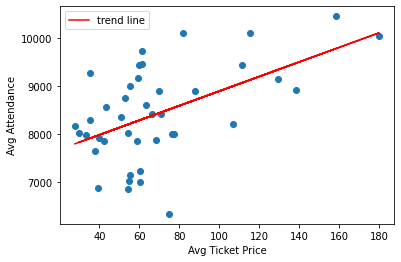

In [131]:
game_attendance = game_attendance.sort_values(by=['Date']).reset_index(drop=True)

x = avg_prices['price']
y = game_attendance['Attendance']

res = stats.linregress(x, y)

print(f"R: {res.rvalue:.6f}")
print(f"R-squared: {res.rvalue**2:.6f}")

plt.plot(x, y, 'o')
plt.xlabel("Avg Ticket Price")
plt.ylabel("Avg Attendance")
plt.plot(x, res.intercept + res.slope*x, 'r', label='trend line')
plt.legend()
plt.show()

Next we are gathering all of the other listed features. See code comments:

In [87]:
# start by selecting all games from games table and grab Opponent information using a join
# NOTE: we are not yet selecting only home games because we want to populate some data from away games
df = sqldf("SELECT [Game Number], [Date], [Start Time], [Game Type], \
           [Opponent], [Result], [Overtime], [Clippers Points], [Opponent Points], \
           [Total Wins], [Total Losses], [Streak], [Playoffs in last year], \
           [Championships], [Vegas Odds for 1819] \
           FROM game g INNER JOIN team t ON g.[Opponent] = t.[Team Full Name]")

# split date into Day of Week, Month, Date (day), and Month 
df['day_of_week'] = df['Date'].str.split(',').str[0].str.strip() # remove whitespace with strip()
df['month'] = df['Date'].str.split(',').str[1].str.split(' ').str[1].str.strip()
df['date'] = df['Date'].str.split(',').str[1].str.split(' ').str[2].str.strip()
df['year'] = df['Date'].str.split(',').str[2].str.strip()

# get dates
dates = df['Date'].str.split(',').str[1] + df['Date'].str.split(',').str[2]
# standardize to Date Time object
dates = pd.to_datetime(dates).dt.date
# replace [Date]
df['Date'] = dates

# shift columns down to avoid looking ahead in time
df['Last Result'] = df['Result'].shift(1)
df['Last Overtime'] = df['Overtime'].shift(1)
df['Last LAC Score'] = df['Clippers Points'].shift(1)
df['Last Opp Score'] = df['Opponent Points'].shift(1)
df['Total Wins'] = df['Total Wins'].shift(1)
df['Total Losses'] = df['Total Losses'].shift(1)

# further shift columns for lagged categories (2 games ago)
df['Lagged Result'] = df['Result'].shift(2)
df['Lagged Overtime'] = df['Overtime'].shift(2)
df['Lagged LAC Score'] = df['Clippers Points'].shift(2)
df['Lagged Opp Score'] = df['Opponent Points'].shift(2)

# split Streak to Direction (W/L) and Magnitude
df['Streak Direction'] = df['Streak'].str[0]
df['Streak Numeric'] = df['Streak'].str[2]

# keep only home games
df = df.drop(df[df['Game Type'] != "Regular Season Home"].index).reset_index(drop=True)

# add sorted game attendance to df
df['Attendance'] = game_attendance['Attendance']
# get last attendance
df['Last Att'] = df['Attendance'].shift(1)
# lagged attendance (2 games ago)
df['Lagged Att'] = df['Attendance'].shift(2)

'''
# add average ticket prices from last cell
df['price'] = avg_prices['price']
'''

# remove unneeded columns: 
df.drop(columns=['Game Type', 'Result', 'Overtime', 'Clippers Points', 'Opponent Points', 'Streak', 'Date'], axis=1, inplace=True)

# let's look at what we have so far
df.head()

,Game Number,Start Time,Opponent,Total Wins,Total Losses,Playoffs in last year,Championships,Vegas Odds for 1819,day_of_week,month,date,year,Last Result,Last Overtime,Last LAC Score,Last Opp Score,Lagged Result,Lagged Overtime,Lagged LAC Score,Lagged Opp Score,Streak Direction,Streak Numeric,Attendance,Last Att,Lagged Att
0,1,10:30p,Denver Nuggets,NaN,NaN,No,0,47.5,Wed,Oct,17,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,1,8173,NaN,NaN
1,2,10:30p,Oklahoma City Thunder,0.0,1.0,Yes,1,50.5,Fri,Oct,19,2018,L,No,98.0,107.0,NaN,NaN,NaN,NaN,W,1,6343,8173.0,NaN
2,3,9:00p,Houston Rockets,1.0,1.0,Yes,2,54.5,Sun,Oct,21,2018,W,No,108.0,92.0,L,No,98.0,107.0,W,2,8009,6343.0,8173.0
3,6,9:30p,Washington Wizards,3.0,2.0,Yes,1,44.5,Sun,Oct,28,2018,W,No,133.0,113.0,L,No,109.0,116.0,W,2,8019,8009.0,6343.0
4,10,10:30p,Minnesota Timberwolves,5.0,4.0,Yes,0,44.5,Mon,Nov,5,2018,W,No,120.0,95.0,L,No,113.0,122.0,W,2,7985,8019.0,8009.0


### Data Cleaning
We've done most of the setup, now we have to clean our data and make sure it is usable in the ways we want when the model is training.

In [88]:
# grab headers
headers = [h for h in df.columns]

# these columns contain numeric data
n_cols = df[headers].select_dtypes(include=np.number).columns.tolist()
print("\nnumeric columns: ", n_cols)

# these columns contain categorical data
c_cols = df[headers].select_dtypes('object').columns.tolist()
print("\ncategorical columns: ", c_cols)

# encode categorical data
df[c_cols] = df[c_cols].astype('category')
df[c_cols] = df[c_cols].apply(lambda x: x.cat.codes)
# replace NaN encodings
df['Last Result'] = df['Last Result'].apply(lambda x : x if x > 0 else 0)
df['Last Overtime'] = df['Last Overtime'].apply(lambda x : x if x > 0 else 0)
df['Lagged Result'] = df['Lagged Result'].apply(lambda x : x if x > 0 else 0)
df['Lagged Overtime'] = df['Lagged Overtime'].apply(lambda x : x if x > 0 else 0)

# replace missing data with the average of the column
df = df.fillna(df.mean())

# show cleaned data
df.head()


numeric columns:  ['Game Number', 'Total Wins', 'Total Losses', 'Championships', 'Vegas Odds for 1819', 'Last LAC Score', 'Last Opp Score', 'Lagged LAC Score', 'Lagged Opp Score', 'Attendance', 'Last Att', 'Lagged Att']

categorical columns:  ['Start Time', 'Opponent', 'Playoffs in last year', 'day_of_week', 'month', 'date', 'year', 'Last Result', 'Last Overtime', 'Lagged Result', 'Lagged Overtime', 'Streak Direction', 'Streak Numeric']


,Game Number,Start Time,Opponent,Total Wins,Total Losses,Playoffs in last year,Championships,Vegas Odds for 1819,day_of_week,month,date,year,Last Result,Last Overtime,Last LAC Score,Last Opp Score,Lagged Result,Lagged Overtime,Lagged LAC Score,Lagged Opp Score,Streak Direction,Streak Numeric,Attendance,Last Att,Lagged Att
0,1,0,7,24.725,18.15,0,0,47.5,6,6,8,0,0,0,114.575,114.9,0,0,116.128205,114.0,0,0,8173,8411.95,8398.923077
1,2,0,19,0.000,1.00,1,1,50.5,0,6,10,0,0,0,98.000,107.0,0,0,116.128205,114.0,1,0,6343,8173.00,8398.923077
2,3,3,10,1.000,1.00,1,2,54.5,3,6,12,0,1,0,108.000,92.0,0,0,98.000000,107.0,1,1,8009,6343.00,8173.000000
3,6,4,28,3.000,2.00,1,1,44.5,3,6,18,0,1,0,133.000,113.0,0,0,109.000000,116.0,1,1,8019,8009.00,6343.000000
4,10,0,16,5.000,4.00,1,0,44.5,1,5,23,0,1,0,120.000,95.0,0,0,113.000000,122.0,1,1,7985,8019.00,8009.000000


In [89]:
# Attendance is what we want to predict
y = df.loc[:,'Attendance']

# remove Attendance from the data we will use to build our model
del df['Attendance']

# update headers
headers = [h for h in df.columns]

# scale data
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=[headers])

# x is data with which we will predict y
x = df.loc[:, headers]

# splitting 90/10 training/test... trying to get all the training we can
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

#### Defining the Neural Network

In [90]:
model = Sequential()
model.add(Dense(24, kernel_initializer='uniform', input_shape=(24,)))
model.add(Dense(48, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss='mse',
                metrics='mae')
history = model.fit(X_train, y_train, epochs=1250, validation_split=0.1, verbose=0)

In [91]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

1/1 [==============================] - 0s 20ms/step - loss: 989030.6250 - mae: 721.4347


In [92]:
# compare to attendance stats
game_attendance.describe()

,Attendance
count,41.000000
mean,8426.170732
std,986.184818
min,6343.000000
25%,7882.000000
50%,8351.000000
75%,9150.000000
max,10445.000000


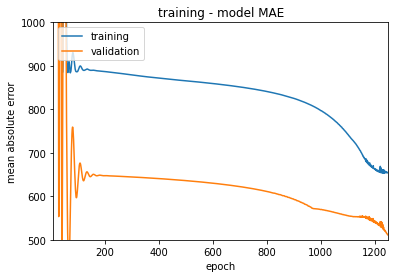

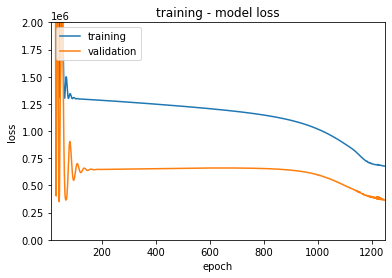

In [116]:
# summarize history for mean absolute error
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('training - model MAE')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.xlim([10, 1250])
plt.ylim([500, 1000])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.xlim([10, 1250])
plt.ylim([0, 2000000])
plt.show()

#### Discussion

Our training went as well as I'd hope given the limited training data. In the graphs of the training history, we can see that both the MAE and loss begin decrease. The divergence occuring toward the last epochs may be signs of overfitting, but we seem to have stopped the training in time.  We're able to get good predictions out of it (__see end of notebook for predictions on the 2019-2020 season__), but there is reason to think it could still improve. Our biggest bottleneck was, and nearly always is, a limited amount of data. Without consistent ways to artifically augment our data (see my CNN work on my GitHub!), we were left with little more than 41 game's worth of information from a single season. While I tried to make up for this by deriving additional features, it was still a limitation. Training on more data (not necessarily more features) and some more advanced feature selection would be reasonable first steps in creating a better model.

### Gradient Boosted Trees (we're not pursuing this)

I tested and trained various NN structures and found that deeper and narrower models tended to perform better. At this point, I also found that significant overfitting to the data generally began to occur at around 1300 epochs.

I anticipated a significant amount of difficulty building any ML model due to the extremely small sample size of only 41 home games from a single season. Just to compare, we're going to try and train a model using Gradient Boosted Decision Trees and see how it performs.

In [112]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline

# Gradient Boosted Trees
gbt = make_pipeline(StandardScaler(), GradientBoostingRegressor(learning_rate=0.06, 
                                                                n_estimators=120,
                                                                max_depth=4, 
                                                                subsample=0.7, 
                                                                random_state=42)).fit(X_train, y_train)

gbt.score(X_test, y_test)

gbt_predictions = gbt.predict(X_test)

# show some predictions
i = 0
for pre in y_test:
    if (i > 10): break
    print("Actual Attendance: " + str(pre) + " | Predicted Attendance: " + str(gbt_predictions[i]))
    i += 1

# model score
print("\nmodel score: " + str(gbt.score(X_test, y_test)))

Actual Attendance: 8032 | Predicted Attendance: 8372.28484685892
Actual Attendance: 9437 | Predicted Attendance: 7915.632295121908
Actual Attendance: 8291 | Predicted Attendance: 7902.288813017753
Actual Attendance: 9432 | Predicted Attendance: 8361.84283614227
Actual Attendance: 6343 | Predicted Attendance: 7974.904063096243

model score: 0.013265730288542499


### Discussion

The Decision Trees Model performed pretty poorly. The Model Score indicates that the model can account for roughly 1.3% of the variance in attendance. Furthermore, the model scores wildly differently after different training sessions, so this score is rather meaningless. This is not useful in a professional setting, though having additional data would again be the next step in creating a better model. We are more accurate than simply guessing the mean attendance, however. 

I primarily wanted to try a Decision Tree model because they are unique in that they are much more interpretable than other models. As a Data Scientist, I often tend to favor "whatever works" to create the most predictive model possible, however in a business setting having more interpretable results are both intellectually stimulating and directly applicable to more tangibly define how we may change organizational practices/behavior. Having more data to train a decision tree could again help with feature selection and be of interest to those in Business Intelligence.

The Neural Network seems like a much more promising avenue, and I would imagine that the LA Clippers employ a range of trained models using strategies such as Recurrent Neural Networks. I would be very interested to see the architecture of such models, and how my model would do with access to more proprietary data.

We will now load the .csv data I created that we need to predict the attendance of the 2019-2020 season's first 32 home games before the league was suspended in March due to Covid-19. See notes below for sources and how I derived data and how I avoied "looking into the future" when doing so.

In [219]:
# for visualizing predictions
translations = pd.read_csv('UNENCODED_Clippers_2019-2020_data.csv')

# data used in predicting
data = pd.read_csv('Clippers_2019-2020_data.csv')
data.head()

,Game Number,Start Time,Opponent,Total Wins,Total Losses,Playoffs in last year,Championships,Vegas Odds for 1819,day_of_week,month,date,year,Last Result,Last Overtime,Last LAC Score,Last Opp Score,Lagged Result,Lagged Overtime,Lagged LAC Score,Lagged Opp Score,Streak Direction,Streak Numeric,Last Att,Lagged Att
0,1,0,12,43,39,0,16,50.5,5,6,22,2019,0.512195,0.073171,118.413636,114.268636,0.560976,0.04878,118.413636,114.268636,0.634146,1.04878,8453.80068,8453.80068
1,4,0,3,43,39,0,0,23.5,1,6,28,2019,0.512195,0.073171,118.413636,114.268636,0.560976,0.04878,118.413636,114.268636,0.634146,1.04878,8453.80068,8453.80068
2,6,0,25,43,39,1,5,46.5,4,6,31,2019,0.512195,0.073171,118.413636,114.268636,0.560976,0.04878,118.413636,114.268636,0.634146,1.04878,8453.80068,8453.80068
3,7,3,27,43,39,1,0,53.5,3,5,3,2019,0.512195,0.073171,118.413636,114.268636,0.560976,0.04878,118.413636,114.268636,0.634146,1.04878,8453.80068,8453.80068
4,8,2,15,43,39,1,1,57.5,6,5,6,2019,0.512195,0.073171,118.413636,114.268636,0.560976,0.04878,118.413636,114.268636,0.634146,1.04878,8453.80068,8453.80068


#### How we populated this data:
- Game Number, Opponent, Date/Time information was taken from the LA Clippers Website, ESPN, and Google
- Playoffs Last Year was coded by looking at whether each opponent made the playoffs in the 2018-2019 season according to ESPN
- Championship odds were taken from Basketball-Reference.com's 2019-20 NBA Preseason Odds
- Championship win totals were taken from the LAC provided information but adjusted for Toronto's win in 2019
- Result/Overtime/Streak used average values of encodings from last year's data
- All Wins, Losses and Opponent Scores (and their lagged variants) were filled using adjusted averages from the 2018-2019 season:
    - **We adjusted the averages based on the historical productivity of new Signees Kawhi Leonard's and Paul George's last season's stats (using FiveThirtyEight's offensive/defensive RAPTOR player ratings).** We multiplied each of their offensive and defensive outputs by 0.3 and adjusted average point totals. This is not empirical, but is trying to estimate their contribution as 40% of the starting lineup.
- We encoded the categories using the same conventions as the training data
    
# Predicting Home Game Attendance in the 2019-2020 Season

In [220]:
# get headers
cols = [h for h in data.columns]

# scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.to_numpy())
data_scaled = pd.DataFrame(data_scaled, columns=[cols])

# re-scaling based on past data's variation
predictions = model.predict(data_scaled)

# translate the mean to 0
predictions = (predictions - predictions.mean()) / (predictions.max() - predictions.min())

# scale to the desired standard deviation 
predictions = predictions * (np.sqrt(y.var()) / np.sqrt(predictions.var()))

# translate to the desired mean.
predictions = predictions + y.mean()

In [221]:
# turn into df
predictions = predictions.flatten()
d = {'Predicted Attendance':predictions}
predictions = pd.DataFrame(d)

# add Game Information
predictions['Opponent'] = translations['Opponent']
predictions['Month'] = translations['month']
predictions['Day'] = translations['date']
predictions['Year'] = translations['year']
predictions['Start Time (EST)'] = translations['Start Time']

predictions

,Predicted Attendance,Opponent,Month,Day,Year,Start Time (EST)
0,9318.271484,Los Angeles Lakers,Oct,22,2019,10:30p
1,7765.118652,Charlotte Hornets,Oct,28,2019,10:30p
2,8579.879883,San Antonio Spurs,Oct,31,2019,10:30p
3,9681.732422,Utah Jazz,Nov,3,2019,9:00p
4,8664.616211,Milwaukee Bucks,Nov,6,2019,10:00p
5,7680.282715,Portland Trail Blazers,Nov,7,2019,10:30p
6,8162.074707,Toronto Raptors,Nov,11,2019,10:30p
7,7748.881348,Atlanta Hawks,Nov,16,2019,10:30p
8,7739.158691,Okalhoma City Thunder,Nov,18,2019,10:30p
9,11305.302734,Boston Celtics,Nov,20,2019,10:00p


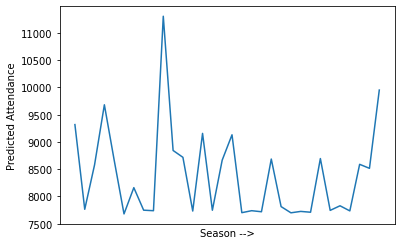

In [225]:
plt.xticks( predictions['Predicted Attendance'], predictions.index.values ) # location, labels
plt.plot( predictions['Predicted Attendance'] )
plt.xlabel("Season -->")
plt.ylabel("Predicted Attendance")
plt.show()

The predictions seem pretty reasonable based on the opponent, dates, game times, etc.